In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
import logging as lg
import time
import os
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import scipy.stats as stats

from sklearn.neighbors import KNeighborsClassifier




In [2]:
#HELPER FUNCTIONS


def cleanData(df:pd.DataFrame,i:int):
    df=df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)
    df['Label']=i
    return df
    
def preprocess_data(X):

    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.dropna()  

  
    for column in X.select_dtypes(include=['object']).columns:

        if not X[column].apply(lambda x: isinstance(x, str)).all():
            X[column] = X[column].astype(str)

        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
    
    return X

def significanceTest(SR,COND):
    significant=[]



    for column in SR.columns:
        if column in COND.columns and column!="Label":  
            srVal = SR[column]
            condVal = COND[column] 
            

            _, p_value = stats.mannwhitneyu(srVal, condVal, alternative='two-sided')
            if p_value<0.05:
                significant.append(column)
    print(significant)
    return significant

def getSplit(files,num=2,scalar=False):

    
    datasets=cleanData(pd.read_csv(f'features{num}/SR.csv',low_memory=False),0).iloc[:1000]
    SR=datasets.copy()
    
    label=1
    for filename in os.listdir(f'features{num}'):
    
        if filename.endswith('.csv') and filename != 'SR.csv' and not "Unknown" in filename and filename in files:
        
            df = cleanData(pd.read_csv(os.path.join(f'features{num}', filename),low_memory=False), label).iloc[:1000]
            sig=significanceTest(SR,df)
            sig.append('Label')
            label+=1
            datasets=pd.concat([datasets[sig],df[sig]])
    
    X = datasets.drop(["Label"], axis =1)
   
    
    Y = datasets["Label"]




    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=42)
    if scalar:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test) 
    return X_train,Y_train, X_test,  Y_test

# MODELS

In [3]:
def RF(X_tr, Y_tr, X_te, Y_te):

    param_grid = {
        'n_estimators': [int(x) for x in np.linspace(start=10, stop=100, num=10)],  
        'max_depth': range(1, 20),  
        'criterion': ['gini', 'entropy'] 
    }


    optimal_params = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=10, 
        scoring='accuracy',
        verbose=0,
        n_jobs=-1
    )


    optimal_params.fit(X_tr, Y_tr)
    print("Best parameters found: ", optimal_params.best_params_)


    criterion = optimal_params.best_params_['criterion']
    max_depth = optimal_params.best_params_['max_depth']
    n_estimators = optimal_params.best_params_['n_estimators']


    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        criterion=criterion,
        random_state=42
    )

    rf_model.fit(X_tr, Y_tr)


    rf_pred = rf_model.predict(X_te)


    plot=ConfusionMatrixDisplay.from_estimator(estimator=rf_model, X=X_te, y=Y_te)
    plot.ax_.set_title('Confusion Matrix')
    plt.show()
    print("Best Cross-Validation Score:",optimal_params.best_score_)
    print("Classification Report: Random Forest")
    print(classification_report(Y_te, rf_pred, digits=2),roc_auc_score(Y_te,rf_pred))
    with open('results.txt', 'a') as f:
        f.write(classification_report(Y_te, rf_pred, digits=2))



In [4]:
def XGBoost(X_tr, Y_tr, X_te, Y_te):
    # X_tr = preprocess_data(X_tr)
    # X_te = preprocess_data(X_te)


    class_weight = compute_class_weight('balanced', classes=np.unique(Y_tr), y=Y_tr)
    lg.info("Starting hyperparameter optimization for XGBoost")


    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
    }

    # Create the model
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        tree_method='hist',
        random_state=42
    )


    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='accuracy',  
        cv=10,  
        verbose=1,
        n_jobs=-1  
    )

  
    grid_search.fit(X_tr, Y_tr)

   
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    lg.info(f"Best parameters found: {best_params}")
    lg.info(f"Best cross-validated F1 score: {best_score:.4f}")

    best_model = grid_search.best_estimator_
    best_model.fit(X_tr, Y_tr)

    print("Best Cross-Validation Score:", grid_search.best_score_)
    xgb_pred = best_model.predict(X_te)

    ConfusionMatrixDisplay.from_estimator(estimator=best_model, X=X_te, y=Y_te)

    print("Classification Report: XGBoost",roc_auc_score(Y_te,xgb_pred))
    report = classification_report(Y_te, xgb_pred, digits=2)
    print(report)

In [5]:
def XGBoostQ(X_tr, Y_tr, X_te, Y_te):
    # X_tr = preprocess_data(X_tr)
    # X_te = preprocess_data(X_te)

    

    xgb_model = xgb.XGBClassifier(
        n_estimators=100,        
        max_depth=5,             
        learning_rate=0.1,      
        subsample=0.8,          
        colsample_bytree=0.8,   
        objective='binary:logistic', 
        tree_method='hist',  
        # device='cuda',          
        random_state=42,
    
    )


    xgb_model.fit(X_tr, Y_tr)


    xgb_pred = xgb_model.predict(X_te)


    ConfusionMatrixDisplay.from_estimator(estimator=xgb_model, X=X_te, y=Y_te)


    print("Classification Report: XGBoost")
    report = classification_report(Y_te, xgb_pred, digits=2)
    print(report)


In [6]:
def SVM(X_tr, Y_tr, X_te, Y_te):
    param_grid = {
            'C': [0.1, 1, 10, 100],  
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],  
            'kernel': ['linear', 'rbf'],  
            'class_weight': ['balanced', None]  
        }


    model = SVC(random_state=42)

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                            cv=5, scoring='accuracy', n_jobs=-1)


    grid_search.fit(X_tr, Y_tr)
    

    print("Best parameters found: ", grid_search.best_params_)

 
    model = grid_search.best_estimator_
    Y_pred = model.predict(X_te)

 
    print("Classification Report:\n", classification_report(Y_te, Y_pred),roc_auc_score(Y_te,Y_pred))
    print("Best Cross-Validation Score:", grid_search.best_score_)
 

    plot = ConfusionMatrixDisplay.from_estimator(estimator=model, X=X_te, y=Y_te)
    plot.ax_.set_title('Confusion Matrix')
    plt.show()

In [7]:
def MLP(X_tr, Y_tr, X_te, Y_te):

    model =  MLPClassifier(hidden_layer_sizes=(400,), max_iter=1000, random_state=42,learning_rate="adaptive")
    

    model.fit(X_tr,Y_tr)
    Y_pred = model.predict(X_te)
    ConfusionMatrixDisplay.from_estimator(estimator=model, X=X_te, y=Y_te)

    print("Classification Report:\n", classification_report(Y_te, Y_pred))

    

In [8]:



def KNN(X_tr, Y_tr, X_te, Y_te):


    model = KNeighborsClassifier()
    

    param_grid = {
        'n_neighbors': [x for x in range(3,9)],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='accuracy')
    

    grid_search.fit(X_tr, Y_tr)
    

    best_model = grid_search.best_estimator_
    

    Y_pred = best_model.predict(X_te)
    
    ConfusionMatrixDisplay.from_estimator(estimator=best_model, X=X_te, y=Y_te)
    
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Score:", grid_search.best_score_)
    print("Classification Report:\n", classification_report(Y_te, Y_pred),roc_auc_score(Y_te,Y_pred))


# TEST

In [9]:
X_tr, Y_tr, X_te, Y_te=getSplit(['MI.csv'],4,True)

['R_N', 'R_L', 'R_P', 'M_s1', ' M_s2', ' M_s3', ' M_s4', ' M_s5', ' M_s6', ' M_s7', ' M_s8', ' M_s9', ' M_s10', ' M_s11', ' M_s12', ' P_s3', ' P_s4', ' P_s5', ' P_s6', ' P_s7', ' P_s8', ' P_s9', ' P_s10', ' P_s11', ' P_s12', ' M_u2', ' M_u3', ' M_u4', ' M_u5', ' M_u7', ' M_u8', ' M_u11', ' M_u12', ' P_u2', ' P_u3', ' P_u6', ' P_u10']


In [10]:

RF(X_tr, Y_tr, X_te, Y_te)

KeyboardInterrupt: 

Best parameters found:  {'C': 1, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70       200
           1       0.70      0.68      0.69       200

    accuracy                           0.69       400
   macro avg       0.70      0.70      0.69       400
weighted avg       0.70      0.69      0.69       400
 0.6950000000000001
Best Cross-Validation Score: 0.703125


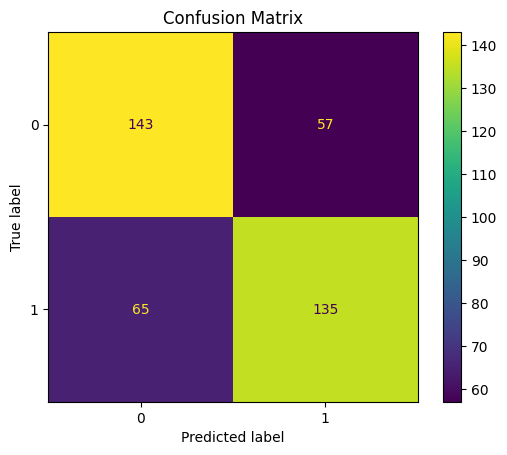

In [33]:
SVM(X_tr, Y_tr, X_te, Y_te)

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69       200
           1       0.69      0.69      0.69       200

    accuracy                           0.69       400
   macro avg       0.69      0.69      0.69       400
weighted avg       0.69      0.69      0.69       400



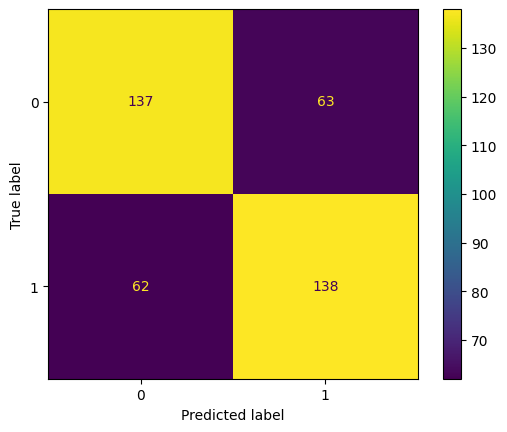

In [34]:
MLP(X_tr, Y_tr, X_te, Y_te)

Classification Report: XGBoost
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       200
           1       0.66      0.67      0.66       200

    accuracy                           0.66       400
   macro avg       0.66      0.66      0.66       400
weighted avg       0.66      0.66      0.66       400



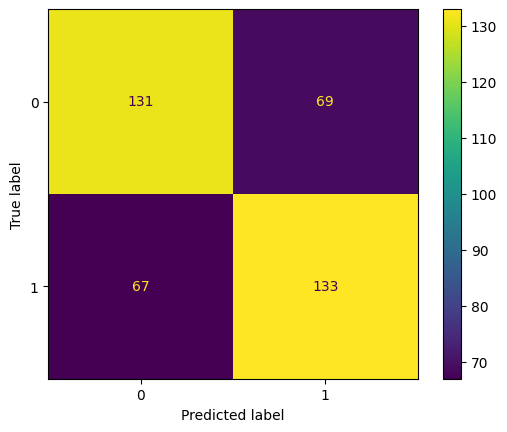

In [35]:
XGBoostQ(X_tr, Y_tr, X_te, Y_te)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits
Best Cross-Validation Score: 0.7118749999999999
Classification Report: XGBoost 0.6924999999999999
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       200
           1       0.69      0.69      0.69       200

    accuracy                           0.69       400
   macro avg       0.69      0.69      0.69       400
weighted avg       0.69      0.69      0.69       400



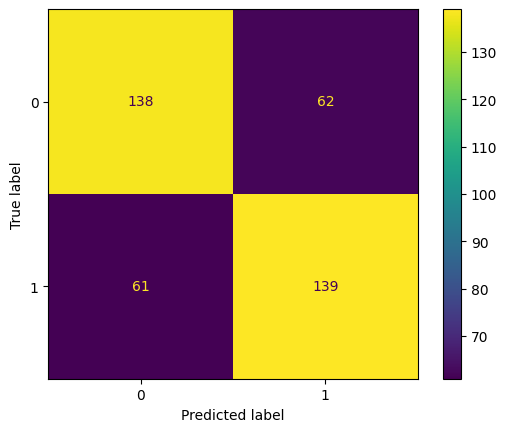

In [36]:
XGBoost(X_tr, Y_tr, X_te, Y_te)

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
Best Cross-Validation Score: 0.656875
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.62      0.63       200
           1       0.63      0.63      0.63       200

    accuracy                           0.63       400
   macro avg       0.63      0.63      0.63       400
weighted avg       0.63      0.63      0.63       400
 0.6275


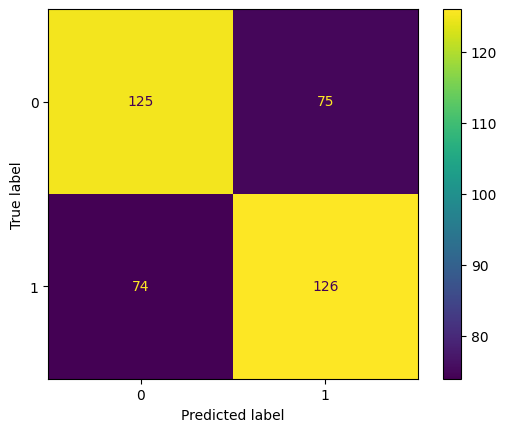

In [37]:
KNN(X_tr, Y_tr, X_te, Y_te)

In [38]:
X_tr, Y_tr, X_te, Y_te=getSplit(['AF.csv'],8,True)

['R_P', 'Lam_max', 'M_s1', ' M_s2', ' M_s4', ' M_s6', ' M_s9', ' M_s11', ' P_s2', ' P_s3', ' P_s4', ' P_s5', ' P_s6', ' P_s7', ' P_s8', ' P_s9', ' P_s10', ' P_s11', ' P_s12', 'M_u1', ' M_u2', ' M_u4', ' M_u6', ' M_u7', ' M_u11', 'P_u1', ' P_u2', ' P_u3', ' P_u4', ' P_u6', ' P_u7', ' P_u8', ' P_u9', ' P_u10', ' P_u11', ' P_u12']


Classification Report: XGBoost
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       200
           1       0.67      0.67      0.67       200

    accuracy                           0.67       400
   macro avg       0.67      0.67      0.67       400
weighted avg       0.67      0.67      0.67       400



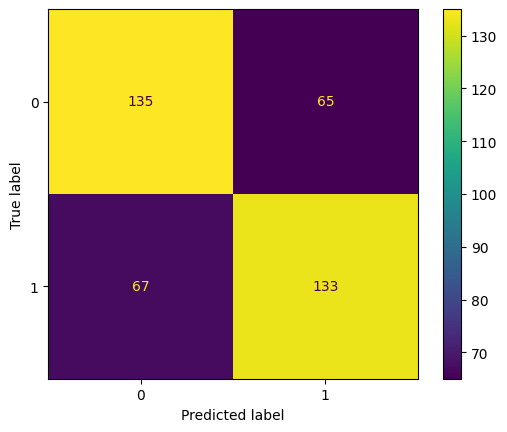

In [39]:
XGBoostQ(X_tr, Y_tr, X_te, Y_te)

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.66       200
           1       0.66      0.66      0.66       200

    accuracy                           0.66       400
   macro avg       0.66      0.66      0.66       400
weighted avg       0.66      0.66      0.66       400



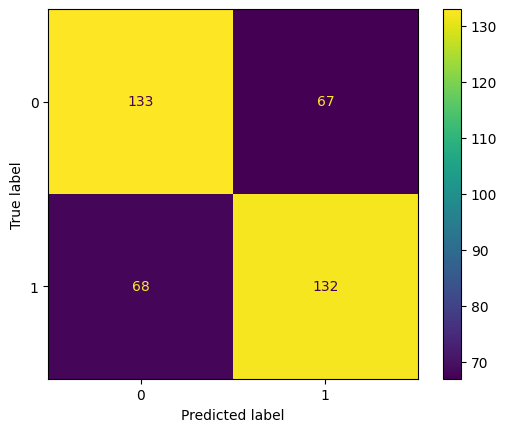

In [40]:
MLP(X_tr, Y_tr, X_te, Y_te)

Best parameters found:  {'C': 10, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.73      0.73       200
           1       0.73      0.72      0.72       200

    accuracy                           0.72       400
   macro avg       0.73      0.72      0.72       400
weighted avg       0.73      0.72      0.72       400
 0.7250000000000001
Best Cross-Validation Score: 0.683125


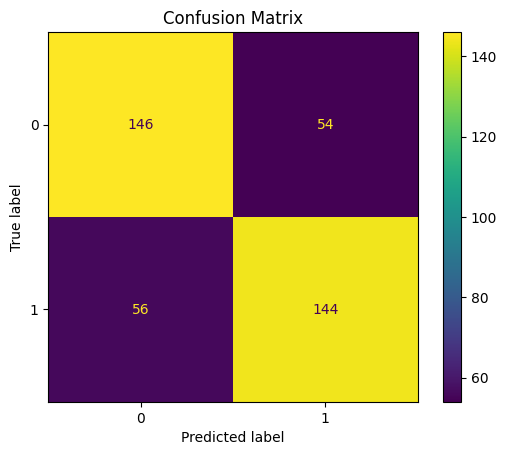

In [41]:
SVM(X_tr, Y_tr, X_te, Y_te)

/home/comp/DMD-project/env/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'criterion': 'entropy', 'max_depth': 16, 'n_estimators': 100}


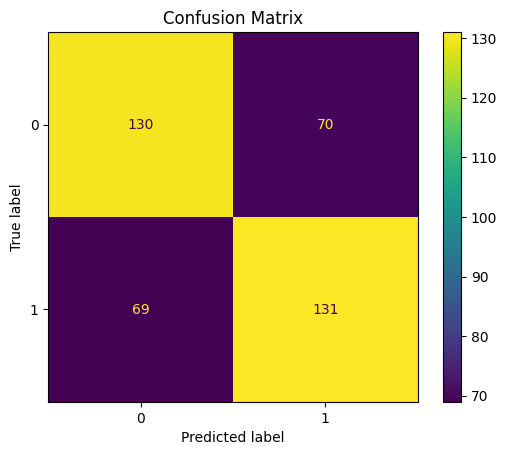

Best Cross-Validation Score: 0.6900000000000001
Classification Report: Random Forest
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       200
           1       0.65      0.66      0.65       200

    accuracy                           0.65       400
   macro avg       0.65      0.65      0.65       400
weighted avg       0.65      0.65      0.65       400
 0.6525


In [42]:
RF(X_tr, Y_tr, X_te, Y_te)

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Best Cross-Validation Score: 0.66125
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.69      0.67       200
           1       0.67      0.62      0.64       200

    accuracy                           0.66       400
   macro avg       0.66      0.66      0.66       400
weighted avg       0.66      0.66      0.66       400
 0.6575000000000001


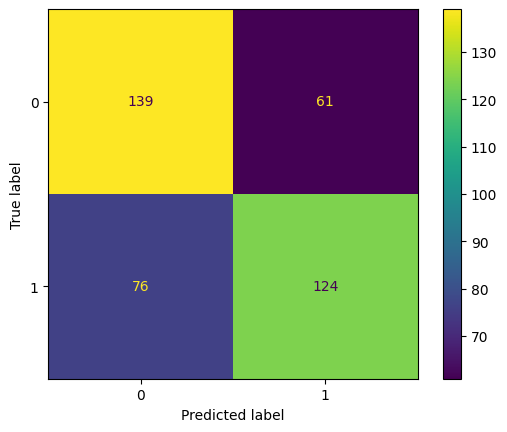

In [43]:
KNN(X_tr, Y_tr, X_te, Y_te)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


/home/comp/DMD-project/env/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Cross-Validation Score: 0.694375
Classification Report: XGBoost 0.6625
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       200
           1       0.65      0.69      0.67       200

    accuracy                           0.66       400
   macro avg       0.66      0.66      0.66       400
weighted avg       0.66      0.66      0.66       400



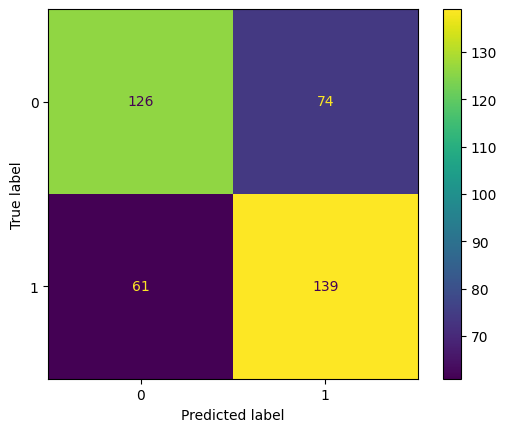

In [44]:
XGBoost(X_tr, Y_tr, X_te, Y_te)